In [ ]:
import os

In [ ]:
try:
    from unsloth import FastVisionModel
except ImportError:
    os.system("pip install --no-deps unsloth bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo")
    os.system("pip install sentencepiece protobuf datasets huggingface_hub hf_transfer transformers[qwen]")
    from unsloth import FastVisionModel

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Unsloth: Could not import trl.trainer.alignprop_trainer: Failed to import trl.trainer.alignprop_trainer because of the following error (look up to see its traceback):
Failed to import trl.models.modeling_sd_base because of the following error (look up to see its traceback):
Failed to import diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion because of the following error (look up to see its traceback):
Failed to import diffusers.loaders.ip_adapter because of the following error (look up to see its traceback):
JITCallable._set_src() takes 1 positional argument but 2 were given
Unsloth: Could not import trl.trainer.ddpo_trainer: Failed to import trl.trainer.ddpo_trainer because of the following error (look up to see its traceback):
Failed to import trl.models.modeling_sd_base because of the following error (look up to see its traceback):
Fa

In [ ]:
# 1. INSTALLATION & IMPORTS
# ==========================================
import torch
import random
import pandas as pd
from tqdm import tqdm
from PIL import Image
from datasets import load_dataset, Dataset, Features, Sequence, Value, Image as HFImage
from peft import PeftModel
from unsloth import FastVisionModel
from huggingface_hub import login

In [ ]:
# 2. LOAD LLAMA MODEL & ADAPTERS
# ==========================================
print("Loading Llama 3.2 Vision Model...")

# Load Base Model (Llama 3.2 11B)
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth",
)

FastVisionModel.for_inference(model)

Loading Llama 3.2 Vision Model...
==((====))==  Unsloth 2025.11.4: Fast Mllama patching. Transformers: 4.57.2.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

MllamaForConditionalGeneration(
  (model): MllamaModel(
    (vision_model): MllamaVisionModel(
      (patch_embedding): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14), padding=valid, bias=False)
      (gated_positional_embedding): MllamaPrecomputedPositionEmbedding(
        (tile_embedding): Embedding(9, 8197120)
      )
      (pre_tile_positional_embedding): MllamaPrecomputedAspectRatioEmbedding(
        (embedding): Embedding(9, 5120)
      )
      (post_tile_positional_embedding): MllamaPrecomputedAspectRatioEmbedding(
        (embedding): Embedding(9, 5120)
      )
      (layernorm_pre): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (layernorm_post): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (transformer): MllamaVisionEncoder(
        (layers): ModuleList(
          (0-12): 13 x MllamaVisionEncoderLayer(
            (self_attn): MllamaVisionAttention(
              (q_proj): Linear4bit(in_features=1280, out_features=1280, bias=False)
       

In [ ]:
# 3. LOAD DATASETS (SEPARATE SUPPORT & QUERY)
# ==========================================
print("Loading Datasets...")

# A. SUPPORT SET (Training Data)
# We will pick few-shot examples from HERE.
# This ensures no test data leakage.
print("Loading Training Data (Support Set)...")
support_dataset = load_dataset("Adyakanta/train_flickr30k", split="test")

# B. QUERY SET (Test Data)
# We will generate captions for THESE images.
print("Loading Test Data (Query Set)...")
query_dataset = load_dataset("Adyakanta/test_flickr30k", split="test")

# Optional: Clean up columns if necessary
support_dataset = support_dataset.remove_columns(['sentids', 'split', 'img_id', 'filename'])
query_dataset = query_dataset.remove_columns(['sentids', 'split', 'img_id', 'filename'])

Loading Datasets...
Loading Training Data (Support Set)...


README.md:   0%|          | 0.00/471 [00:00<?, ?B/s]

data/test-00000-of-00006.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

data/test-00001-of-00006.parquet:   0%|          | 0.00/483M [00:00<?, ?B/s]

data/test-00002-of-00006.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

data/test-00003-of-00006.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

data/test-00004-of-00006.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

data/test-00005-of-00006.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/21000 [00:00<?, ? examples/s]

Loading Test Data (Query Set)...


README.md:   0%|          | 0.00/469 [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/14.6M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
# 4. FEW-SHOT INFERENCE FUNCTION
def get_few_shot_prediction(target_image, support_dataset, model, tokenizer, num_shots=3, num_return_sequences=5):
    """
    Uses random examples from 'support_dataset' (Training) to prompt for 'target_image' (Test).
    Generates 'num_return_sequences' diverse captions.
    """

    # --- Step A: Select Shots from SUPPORT Dataset ---
    # We pick random indices from the training data
    # Since support and query are different datasets, we don't need to exclude the target index.
    possible_indices = list(range(len(support_dataset)))
    shot_indices = random.sample(possible_indices, num_shots)

    messages = []
    images_list = []
    instruction = "Write a descriptive caption for this image."

    # --- Step B: Build Context (From Training Data) ---
    for idx in shot_indices:
        sample = support_dataset[idx]
        images_list.append(sample["image"])

        # User Turn: Image + Instruction
        messages.append({
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": instruction}
            ]
        })

        # Assistant Turn: Gold Caption from Training Data
        # Handle if caption is list or string
        caption_text = sample["caption"][0] if isinstance(sample["caption"], list) else sample["caption"]
        messages.append({
            "role": "assistant",
            "content": [{"type": "text", "text": caption_text}]
        })

    # --- Step C: Add Target (From Test Data) ---
    # We add the target image (passed as argument) to the list
    images_list.append(target_image)

    messages.append({
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": instruction}
        ]
    })

    # --- Step D: Tokenize ---
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

    inputs = tokenizer(
        images=images_list,
        text=[input_text],
        padding=True,
        return_tensors="pt"
    ).to("cuda")

    # --- Step E: Diversity Generation Loop ---
    generated_captions = []

    # We loop explicitly to force the model to re-sample and create diverse outputs
    for _ in range(num_return_sequences):
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=128,
                use_cache=True,

                # Sampling parameters for diversity
                do_sample=True,
                temperature=0.8,
                top_p=0.9,
                top_k=50,
                min_p=0.0,

                num_return_sequences=1 # Generate one at a time per loop iteration
            )

        # Decode only the new tokens
        generated_ids = outputs[0][len(inputs.input_ids[0]):]
        response = tokenizer.decode(generated_ids, skip_special_tokens=True)
        generated_captions.append(response)

    return generated_captions

In [ ]:
# 5. RUN INFERENCE ON 100 SAMPLES
# ==========================================
print("\nStarting Llama 3.2 Few-Shot Inference (Sampled)...")
results = []

# Process 100 samples
for i in tqdm(range(min(100, len(query_dataset)))):
    try:
        target_img = query_dataset[i]["image"]
        target_cap = query_dataset[i]["caption"]

        # Generate
        generated_captions_list = get_few_shot_prediction(
            target_image=target_img,
            support_dataset=support_dataset,
            model=model,
            tokenizer=tokenizer,
            num_shots=3,
            num_return_sequences=5
        )

        results.append({
            "image": target_img,
            "original_response": target_cap,
            "generated_response": generated_captions_list
        })

        if i == 0:
            print(f"\n--- Sample Llama Generation (Image 0) ---")
            for idx, cap in enumerate(generated_captions_list):
                print(f"{idx+1}: {cap}")

    except Exception as e:
        print(f"Error at index {i}: {e}")


Starting Llama 3.2 Few-Shot Inference (Sampled)...


  1%|          | 1/100 [01:18<2:09:43, 78.62s/it]


--- Sample Llama Generation (Image 0) ---
1: A young boy with blonde hair and a big smile is wearing a Santa outfit and holding a guitar.
2: A person in a red Santa outfit is holding a red and white ornament and standing in front of a Christmas tree.
3: A young boy is riding a small, toy-sized motorcycle in front of a wooden door.
4: A woman is holding a child on her lap and they are looking at a baby in a stroller in front of them.
5: A young boy is playing the piano while sitting on the floor, looking directly at the camera.


100%|██████████| 100/100 [30:39<00:00, 18.39s/it]


In [ ]:
# 6. SAVE AND UPLOAD
# ==========================================
# Authenticate
# login() # Uncomment if you need to login interactively
from huggingface_hub import notebook_login
notebook_login()


print("Creating Hugging Face Dataset...")
df_few_shot = pd.DataFrame(results)

# --- DATA PROCESSING ---
images_list = df_few_shot['image'].tolist()

# Ensure Original Responses are lists
original_responses = []
for item in df_few_shot['original_response'].tolist():
    if isinstance(item, list):
        original_responses.append(item)
    else:
        original_responses.append([item])

# Ensure Generated Responses are lists
generated_responses = []
for item in df_few_shot['generated_response'].tolist():
    if isinstance(item, list):
        generated_responses.append(item)
    else:
        generated_responses.append([item])

# --- DEFINE FEATURES ---
features = Features({
    'image': HFImage(),
    'original_response': Sequence(Value('string')),
    'generated_response': Sequence(Value('string')),
})

# Create Dataset
ds_few_shot = Dataset.from_dict({
    'image': images_list,
    'original_response': original_responses,
    'generated_response': generated_responses,
}, features=features)

# Push
repo_id = "Adyakanta/LLama_Base_test_caption_few_shot_sampled"
print(f"Pushing to {repo_id}...")
ds_few_shot.push_to_hub(repo_id)
print("✅ Upload Complete!")

Creating Hugging Face Dataset...
Pushing to Adyakanta/LLama_Base_test_caption_few_shot_sampled...


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              :  98%|#########7| 4.09MB / 4.18MB            

✅ Upload Complete!


# **Conversion of A List of Strings to List of Lists**

In [8]:
import pandas as pd
import numpy as np
import ast
import nltk
from datasets import load_dataset
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

In [9]:
# 7. RELOAD AND REFORMAT DATA (FIXED)
# ==========================================
from datasets import load_dataset
import pandas as pd
import numpy as np

print("Loading dataset from Hugging Face...")
dataset_reloaded = load_dataset("Adyakanta/LLama_Base_test_caption_few_shot_sampled", split="train")
df_results = dataset_reloaded.to_pandas()

# Robust function to handle Lists OR Numpy Arrays
def format_as_list_of_lists(caption_data):
    # If it's a numpy array, convert to list first
    if isinstance(caption_data, np.ndarray):
        caption_data = caption_data.tolist()

    # Now process if it is a list
    if isinstance(caption_data, list):
        return [[str(cap)] for cap in caption_data]

    return []

print("Reformatting columns...")
# Apply the transformation
df_results['original_response_formatted'] = df_results['original_response'].apply(format_as_list_of_lists)
df_results['generated_response_formatted'] = df_results['generated_response'].apply(format_as_list_of_lists)

# Check the results
print("\n--- Sample Transformation (Image 0) ---")
print("Original (Before):")
print(df_results['original_response'][0])

print("\nFormatted (After):")
print(df_results['original_response_formatted'][0])

print("\nGenerated (After):")
print(df_results['generated_response_formatted'][0])

Loading dataset from Hugging Face...
Reformatting columns...

--- Sample Transformation (Image 0) ---
Original (Before):
['The baby his a Cookie Monster outfit on he is happy he his a Gutter its red'
 "A child wearing a shirt decorated with Elmo's face holds a red ukulele."
 'A toddler wearing an Elmo Christmas outfit holds a red guitar.'
 'A child wearing a santa elmo suit holding a red guitar.'
 'A child in a Elmo suit is playing the guitar.']

Formatted (After):
[['The baby his a Cookie Monster outfit on he is happy he his a Gutter its red'], ["A child wearing a shirt decorated with Elmo's face holds a red ukulele."], ['A toddler wearing an Elmo Christmas outfit holds a red guitar.'], ['A child wearing a santa elmo suit holding a red guitar.'], ['A child in a Elmo suit is playing the guitar.']]

Generated (After):
[['A young boy with blonde hair and a big smile is wearing a Santa outfit and holding a guitar.'], ['A person in a red Santa outfit is holding a red and white ornament and

In [10]:
df_results.drop(columns=['original_response'], inplace=True)
df_results.drop(columns=['generated_response'], inplace=True)

In [11]:
df_results

,image,original_response_formatted,generated_response_formatted
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,[[The baby his a Cookie Monster outfit on he i...,[[A young boy with blonde hair and a big smile...
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,[[A man without a shirt runs through water spr...,[[The image shows a large fountain with water ...
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[[A young woman in a blue shirt stands, holdin...",[[A person in a blue shirt is holding a small ...
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,[[A woman is walking down a trail with tall gr...,[[A woman wearing a tank top and shorts is wal...
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,[[A large black gorilla peers down at a group ...,"[[A group of people gather around a DJ booth, ..."
...,...,...,...
95,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[[Three men in yellow hard hats, two women, an...",[[A little boy dressed in a hard hat and refle...
96,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,[[A blond girl is sitting drinking a soda and ...,"[[A dog in the ocean with a person.], [A girl ..."
97,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,[[The Oklahoma football player watches the gam...,[[A football player wearing a red jersey with ...
98,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,[[A boy in a striped shirt with his arm stretc...,[[A young boy with a striped shirt is playing ...


In [12]:
import io
from PIL import Image

def convert_image_bytes_to_pil(image_entry):
    """
    Converts an image entry (dictionary with 'bytes' key) to a PIL Image object.
    """
    if isinstance(image_entry, dict) and 'bytes' in image_entry:
        image_bytes = image_entry['bytes']
        return Image.open(io.BytesIO(image_bytes))
    return None # Or raise an error if non-dict entries are unexpected

print("Converting 'image' column to PIL Image objects...")
df_results['image'] = df_results['image'].apply(convert_image_bytes_to_pil)
print("Conversion complete. Displaying first few rows with updated 'image' column:")
print(df_results.head())

Converting 'image' column to PIL Image objects...
Conversion complete. Displaying first few rows with updated 'image' column:
                                               image  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                         original_response_formatted  \
0  [[The baby his a Cookie Monster outfit on he i...   
1  [[A man without a shirt runs through water spr...   
2  [[A young woman in a blue shirt stands, holdin...   
3  [[A woman is walking down a trail with tall gr...   
4  [[A large black gorilla peers down at a group ...   

                        generated_response_formatted  
0  [[A young boy with blonde hair and a big smile...  
1  [[The image shows a large fountain with water ...  
2  [[A person in a blue shirt is ho

In [13]:
df_results

,image,original_response_formatted,generated_response_formatted
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,[[The baby his a Cookie Monster outfit on he i...,[[A young boy with blonde hair and a big smile...
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,[[A man without a shirt runs through water spr...,[[The image shows a large fountain with water ...
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[[A young woman in a blue shirt stands, holdin...",[[A person in a blue shirt is holding a small ...
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,[[A woman is walking down a trail with tall gr...,[[A woman wearing a tank top and shorts is wal...
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,[[A large black gorilla peers down at a group ...,"[[A group of people gather around a DJ booth, ..."
...,...,...,...
95,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[[Three men in yellow hard hats, two women, an...",[[A little boy dressed in a hard hat and refle...
96,<PIL.JpegImagePlugin.JpegImageFile image mode=...,[[A blond girl is sitting drinking a soda and ...,"[[A dog in the ocean with a person.], [A girl ..."
97,<PIL.JpegImagePlugin.JpegImageFile image mode=...,[[The Oklahoma football player watches the gam...,[[A football player wearing a red jersey with ...
98,<PIL.JpegImagePlugin.JpegImageFile image mode=...,[[A boy in a striped shirt with his arm stretc...,[[A young boy with a striped shirt is playing ...


In [14]:
output_csv_file = 'LLama_base_few_shot_sampled.csv'
df_results.to_csv(output_csv_file, index=False)
print(f"DataFrame saved to '{output_csv_file}' successfully.")

DataFrame saved to 'LLama_base_few_shot_sampled.csv' successfully.


# **Evaluation Metrics**

# **BLEU-1 AND BLEU-2**

In [ ]:
# # ==========================================
# # 8. CALCULATE BLEU-1 SCORES
# # ==========================================
# import nltk
# from nltk.translate.bleu_score import sentence_bleu
# import numpy as np

# # Ensure necessary NLTK data is downloaded (for tokenization)
# try:
#     nltk.data.find('tokenizers/punkt')
# except LookupError:
#     nltk.download('punkt')

# try:
#     nltk.data.find('tokenizers/punkt_tab')
# except LookupError:
#     # The error indicates that 'punkt_tab' is also required
#     nltk.download('punkt_tab')

# def calculate_avg_bleu1(row):
#     """
#     Calculates the average BLEU-1 score for a set of generated captions
#     against a set of reference captions.
#     """
#     # 1. Extract strings from your list-of-lists format [['cap'], ['cap']] -> ['cap', 'cap']
#     refs_text = [item[0] for item in row['original_response_formatted']]
#     hyps_text = [item[0] for item in row['generated_response_formatted']]

#     # 2. Tokenize References (Ground Truth)
#     # Format: list of lists of tokens [[w1, w2], [w1, w3]]
#     ref_tokens = [nltk.word_tokenize(r.lower()) for r in refs_text]

#     scores = []

#     # 3. Evaluate each Generated Caption
#     for hyp in hyps_text:
#         hyp_token = nltk.word_tokenize(hyp.lower())

#         # Calculate BLEU-1 (Weights: 1.0 for 1-grams)
#         # Smoothing is often useful, but for pure BLEU-1 on full sentences, standard is fine.
#         score = sentence_bleu(ref_tokens, hyp_token, weights=(1.0, 0, 0, 0))
#         scores.append(score)

#     # 4. Return the average score for this image
#     return np.mean(scores) if scores else 0.0

# print("Calculating BLEU-1 Scores...")

# # Apply the function to every row
# df_results['bleu_1'] = df_results.apply(calculate_avg_bleu1, axis=1)

# # Calculate dataset average
# average_bleu1 = df_results['bleu_1'].mean()

# print(f"\n===============================")
# print(f"Average BLEU-1 Score: {average_bleu1:.4f}")
# print(f"===============================")

# # Show a sample with score
# print("\n--- Sample Result ---")
# print(f"Generated: {df_results['generated_response_formatted'][0]}")
# print(f"BLEU-1:    {df_results['bleu_1'][0]:.4f}")

Calculating BLEU-1 Scores...


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram o


Average BLEU-1 Score: 0.5163

--- Sample Result ---
Generated: [['A young boy with blonde hair and a big smile is wearing a Santa outfit and holding a guitar.'], ['A person in a red Santa outfit is holding a red and white ornament and standing in front of a Christmas tree.'], ['A young boy is riding a small, toy-sized motorcycle in front of a wooden door.'], ['A woman is holding a child on her lap and they are looking at a baby in a stroller in front of them.'], ['A young boy is playing the piano while sitting on the floor, looking directly at the camera.']]
BLEU-1:    0.4227


In [ ]:
# ==========================================
# 8. STATISTICAL ANALYSIS (MAX BLEU - BEST OF 5)
# ==========================================
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Use the same smoothing as before for consistency
chencherry = SmoothingFunction()

def calculate_image_max_bleu_scores(original_formatted, generated_formatted):
    """
    Calculates the MAX BLEU-1 and BLEU-2 score for a single image.
    It checks all 5 generated captions and picks the BEST one.
    """
    # 1. Flatten lists
    refs = [item[0] for item in original_formatted]
    hyps = [item[0] for item in generated_formatted]

    # 2. Tokenize
    ref_tokens = [r.lower().split() for r in refs]
    hyp_tokens_list = [h.lower().split() for h in hyps]

    b1_scores = []
    b2_scores = []

    # 3. Evaluate each generated caption against ALL references
    for hyp_tokens in hyp_tokens_list:
        # Calculate score for this specific candidate
        b1 = sentence_bleu(ref_tokens, hyp_tokens, weights=(1, 0, 0, 0), smoothing_function=chencherry.method1)
        b2 = sentence_bleu(ref_tokens, hyp_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=chencherry.method1)

        b1_scores.append(b1)
        b2_scores.append(b2)

    # 4. Return the MAX score (Best of N) instead of Mean
    # This matches your Zero-Shot logic
    return np.max(b1_scores), np.max(b2_scores)

print("Calculating MAX BLEU scores for Few-Shot...")

# Apply calculation
bleu_results = [
    calculate_image_max_bleu_scores(orig, gen)
    for orig, gen in zip(df_results['original_response_formatted'], df_results['generated_response_formatted'])
]

bleu1_all, bleu2_all = zip(*bleu_results)

df_results['BLEU_1_Max'] = bleu1_all
df_results['BLEU_2_Max'] = bleu2_all

# --- DISPLAY REPORT ---
print("\n" + "="*40)
print("   FEW-SHOT RESULTS (MAX METRIC)")
print("="*40)

print(f"Mean Max BLEU-1: {df_results['BLEU_1_Max'].mean():.4f}")
print(f"Mean Max BLEU-2: {df_results['BLEU_2_Max'].mean():.4f}")

print("\nDetailed Stats:")
print(df_results[['BLEU_1_Max', 'BLEU_2_Max']].describe())

Calculating MAX BLEU scores for Few-Shot...

   FEW-SHOT RESULTS (MAX METRIC)
Mean Max BLEU-1: 0.6195
Mean Max BLEU-2: 0.4510

Detailed Stats:
       BLEU_1_Max  BLEU_2_Max
count  100.000000  100.000000
mean     0.619487    0.450955
std      0.147468    0.153270
min      0.272727    0.162221
25%      0.525172    0.345086
50%      0.615385    0.434269
75%      0.709821    0.521168
max      1.000000    0.912871


In [ ]:
##MEAN OF 5 #########
# ==========================================


# import pandas as pd
# import numpy as np
# from nltk.translate.bleu_score import sentence_bleu
# from nltk.tokenize import word_tokenize
# import nltk
# import warnings

# # Ensure nltk resources are available (same as your code)
# try:
#     nltk.data.find('tokenizers/punkt')
# except LookupError:
#     nltk.download('punkt')
#     nltk.download('punkt_tab')

# warnings.filterwarnings('ignore')

# # --- 1. DEFINE YOUR SPECIFIC SCORING FUNCTIONS ---
# def calculate_bleu_scores(candidate, reference):
#     candidate_tokens = word_tokenize(candidate.lower())
#     reference_tokens = word_tokenize(reference.lower())
#     try:
#         # BLEU-1
#         bleu1 = sentence_bleu([reference_tokens], candidate_tokens, weights=(1, 0, 0, 0))
#         # BLEU-2
#         bleu2 = sentence_bleu([reference_tokens], candidate_tokens, weights=(0.5, 0.5, 0, 0))
#         return bleu1, bleu2
#     except:
#         return 0.0, 0.0

# def extract_sentences(nested_list):
#     sentences = []
#     for item in nested_list:
#         if isinstance(item, list):
#             sentences.extend(extract_sentences(item))
#         elif isinstance(item, str):
#             sentences.append(item)
#     return sentences

# def calculate_max_bleu_for_row(generated_responses, original_responses):
#     # Extract sentences using your logic
#     gen_sentences = extract_sentences(generated_responses)
#     orig_sentences = extract_sentences(original_responses)

#     bleu1_scores = []
#     bleu2_scores = []

#     # Compare EVERY generated caption against EVERY original caption
#     for gen in gen_sentences:
#         for orig in orig_sentences:
#             bleu1, bleu2 = calculate_bleu_scores(gen, orig)
#             bleu1_scores.append(bleu1)
#             bleu2_scores.append(bleu2)

#     # Take the MAX (Optimistic Score)
#     max_bleu1 = max(bleu1_scores) if bleu1_scores else 0.0
#     max_bleu2 = max(bleu2_scores) if bleu2_scores else 0.0

#     return max_bleu1, max_bleu2

# # --- 2. APPLY TO YOUR FEW-SHOT DATAFRAME ---
# # Assuming 'df_results' is the dataframe from the previous step
# # containing 'original_response_formatted' and 'generated_response_formatted'

# print("Calculating MAX BLEU scores for Few-Shot results...")

# max_b1_list = []
# max_b2_list = []

# for index, row in df_results.iterrows():
#     # We use the formatted columns we created in Step 7
#     # These are already lists of lists: [['cap1'], ['cap2']...]
#     gen = row['generated_response_formatted']
#     orig = row['original_response_formatted']

#     b1, b2 = calculate_max_bleu_for_row(gen, orig)
#     max_b1_list.append(b1)
#     max_b2_list.append(b2)

# # Add to dataframe
# df_results['max_bleu1_score'] = max_b1_list
# df_results['max_bleu2_score'] = max_b2_list

# # --- 3. PRINT STATISTICS (APPLES-TO-APPLES) ---
# print("\n" + "="*40)
# print("   FEW-SHOT RESULTS (MAX SCORE METHOD)")
# print("="*40)

# print(f"Mean Max BLEU-1: {df_results['max_bleu1_score'].mean():.4f}  (vs Zero-Shot: 0.5918)")
# print(f"Mean Max BLEU-2: {df_results['max_bleu2_score'].mean():.4f}  (vs Zero-Shot: 0.4442)")

# # Additional Stats
# print("\nDetailed Statistics:")
# print(df_results[['max_bleu1_score', 'max_bleu2_score']].describe())

# # Save for your paper
# df_results.to_csv('qwen_few_shot_max_scores.csv', index=False)
# print("\nSaved to 'qwen_few_shot_max_scores.csv'")

# **BLEU-3 AND BLEU-4**

In [ ]:
# ==========================================
# 10. CALCULATE MAX BLEU-3 & BLEU-4
# ==========================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Smoothing method 1 (Standard for NLTK)
chencherry = SmoothingFunction()

def calculate_higher_order_bleu(original_formatted, generated_formatted):
    """
    Calculates the MAX BLEU-3 and BLEU-4 for a single image.
    """
    refs = [item[0] for item in original_formatted]
    hyps = [item[0] for item in generated_formatted]

    ref_tokens = [r.lower().split() for r in refs]
    hyp_tokens_list = [h.lower().split() for h in hyps]

    b3_scores = []
    b4_scores = []

    for hyp_tokens in hyp_tokens_list:
        # BLEU-3 (Weights: 1/3, 1/3, 1/3)
        b3 = sentence_bleu(ref_tokens, hyp_tokens, weights=(0.333, 0.333, 0.333, 0), smoothing_function=chencherry.method1)

        # BLEU-4 (Weights: 1/4, 1/4, 1/4, 1/4)
        b4 = sentence_bleu(ref_tokens, hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method1)

        b3_scores.append(b3)
        b4_scores.append(b4)

    # Return MAX scores (Best-of-N)
    return np.max(b3_scores), np.max(b4_scores)

print("Calculating BLEU-3 and BLEU-4...")

# Run calculation
higher_bleu_results = [
    calculate_higher_order_bleu(orig, gen)
    for orig, gen in zip(df_results['original_response_formatted'], df_results['generated_response_formatted'])
]

b3_all, b4_all = zip(*higher_bleu_results)

df_results['BLEU_3_Max'] = b3_all
df_results['BLEU_4_Max'] = b4_all

# --- PRINT STATS ---
print("\n" + "="*40)
print("   HIGHER ORDER BLEU SCORES (MAX)")
print("="*40)
print(f"Mean BLEU-3: {df_results['BLEU_3_Max'].mean():.4f}")
print(f"Mean BLEU-4: {df_results['BLEU_4_Max'].mean():.4f}")

Calculating BLEU-3 and BLEU-4...

   HIGHER ORDER BLEU SCORES (MAX)
Mean BLEU-3: 0.3138
Mean BLEU-4: 0.2197


Calculating BLEU-3 and BLEU-4...

   ADVANCED BLEU STATS (FEW-SHOT)
Mean BLEU-1: 0.6195
Mean BLEU-2: 0.4510
Mean BLEU-3: 0.3138
Mean BLEU-4: 0.2197

Detailed Statistics:
       BLEU_1_Max  BLEU_2_Max  BLEU_3_Max  BLEU_4_Max
count  100.000000  100.000000  100.000000  100.000000
mean     0.619487    0.450955    0.313844    0.219693
std      0.147468    0.153270    0.157090    0.142547
min      0.272727    0.162221    0.052874    0.033241
25%      0.525172    0.345086    0.213059    0.094189
50%      0.615385    0.434269    0.289748    0.205494
75%      0.709821    0.521168    0.385234    0.306002
max      1.000000    0.912871    0.769083    0.610474

Graphs saved as 'bleu_score_analysis.png'


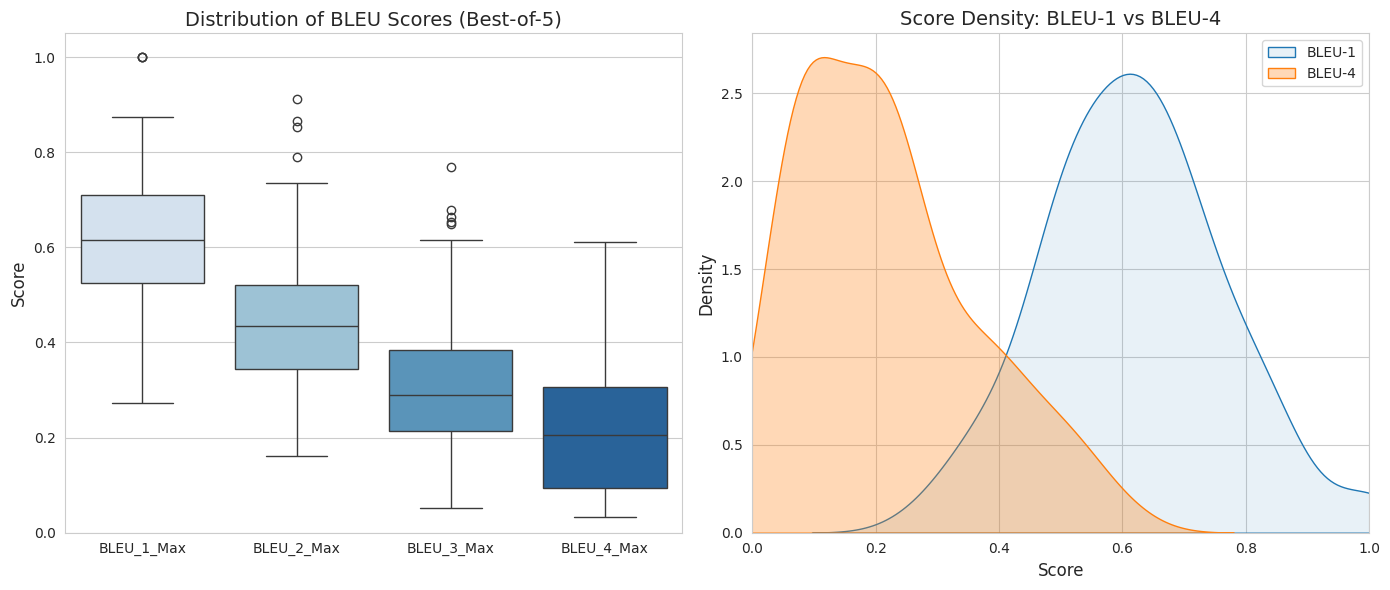

In [ ]:
# ==========================================
# 10. CALCULATE BLEU-3 & BLEU-4 (AND PLOTS)
# ==========================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Ensure smoothing is defined
chencherry = SmoothingFunction()

def calculate_advanced_bleu_scores(original_formatted, generated_formatted):
    """
    Calculates MAX BLEU-3 and BLEU-4 for a single image (Best-of-N).
    """
    refs = [item[0] for item in original_formatted]
    hyps = [item[0] for item in generated_formatted]

    # Tokenize
    ref_tokens = [r.lower().split() for r in refs]
    hyp_tokens_list = [h.lower().split() for h in hyps]

    b3_scores = []
    b4_scores = []

    for hyp_tokens in hyp_tokens_list:
        # BLEU-3 (Cumulative 3-gram)
        b3 = sentence_bleu(ref_tokens, hyp_tokens, weights=(0.333, 0.333, 0.333, 0), smoothing_function=chencherry.method1)

        # BLEU-4 (Cumulative 4-gram)
        b4 = sentence_bleu(ref_tokens, hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method1)

        b3_scores.append(b3)
        b4_scores.append(b4)

    # Return MAX scores (Best attempt)
    return np.max(b3_scores), np.max(b4_scores)

print("Calculating BLEU-3 and BLEU-4...")

# Apply calculation
advanced_bleu_results = [
    calculate_advanced_bleu_scores(orig, gen)
    for orig, gen in zip(df_results['original_response_formatted'], df_results['generated_response_formatted'])
]

b3_all, b4_all = zip(*advanced_bleu_results)

df_results['BLEU_3_Max'] = b3_all
df_results['BLEU_4_Max'] = b4_all

# --- STATISTICAL REPORT ---
print("\n" + "="*40)
print("   ADVANCED BLEU STATS (FEW-SHOT)")
print("="*40)
print(f"Mean BLEU-1: {df_results['BLEU_1_Max'].mean():.4f}")
print(f"Mean BLEU-2: {df_results['BLEU_2_Max'].mean():.4f}")
print(f"Mean BLEU-3: {df_results['BLEU_3_Max'].mean():.4f}")
print(f"Mean BLEU-4: {df_results['BLEU_4_Max'].mean():.4f}")

print("\nDetailed Statistics:")
stats = df_results[['BLEU_1_Max', 'BLEU_2_Max', 'BLEU_3_Max', 'BLEU_4_Max']].describe()
print(stats)

# ==========================================
# 11. GRAPHICAL ANALYSIS
# ==========================================
# Set visual style
sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))

# --- Plot 1: Box Plot (Distribution Summary) ---
plt.subplot(1, 2, 1)
data_to_plot = df_results[['BLEU_1_Max', 'BLEU_2_Max', 'BLEU_3_Max', 'BLEU_4_Max']]
sns.boxplot(data=data_to_plot, palette="Blues")
plt.title('Distribution of BLEU Scores (Best-of-5)', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1.05)

# --- Plot 2: Kernel Density Estimate (Score Density) ---
plt.subplot(1, 2, 2)
sns.kdeplot(df_results['BLEU_1_Max'], label='BLEU-1', fill=True, alpha=0.1)
sns.kdeplot(df_results['BLEU_4_Max'], label='BLEU-4', fill=True, alpha=0.3)
plt.title('Score Density: BLEU-1 vs BLEU-4', fontsize=14)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.xlim(0, 1)

plt.tight_layout()
plt.savefig("bleu_score_analysis.png")
print("\nGraphs saved as 'bleu_score_analysis.png'")
plt.show()

# **ROGUE L/1/2 METRIC**


Calculating MAX ROUGE scores...

   FEW-SHOT ROUGE RESULTS (MAX METRIC)
Mean Max ROUGE-1: 0.5375
Mean Max ROUGE-2: 0.2815
Mean Max ROUGE-L: 0.4869

Detailed Stats:
       ROUGE_1_Max  ROUGE_2_Max  ROUGE_L_Max
count   100.000000   100.000000   100.000000
mean      0.537503     0.281519     0.486875
std       0.099644     0.109819     0.107070
min       0.333333     0.088889     0.297872
25%       0.470588     0.212438     0.400000
50%       0.527864     0.264912     0.482759
75%       0.608696     0.333333     0.555556
max       0.782609     0.608696     0.782609

Graphs saved as 'rouge_score_analysis.png'


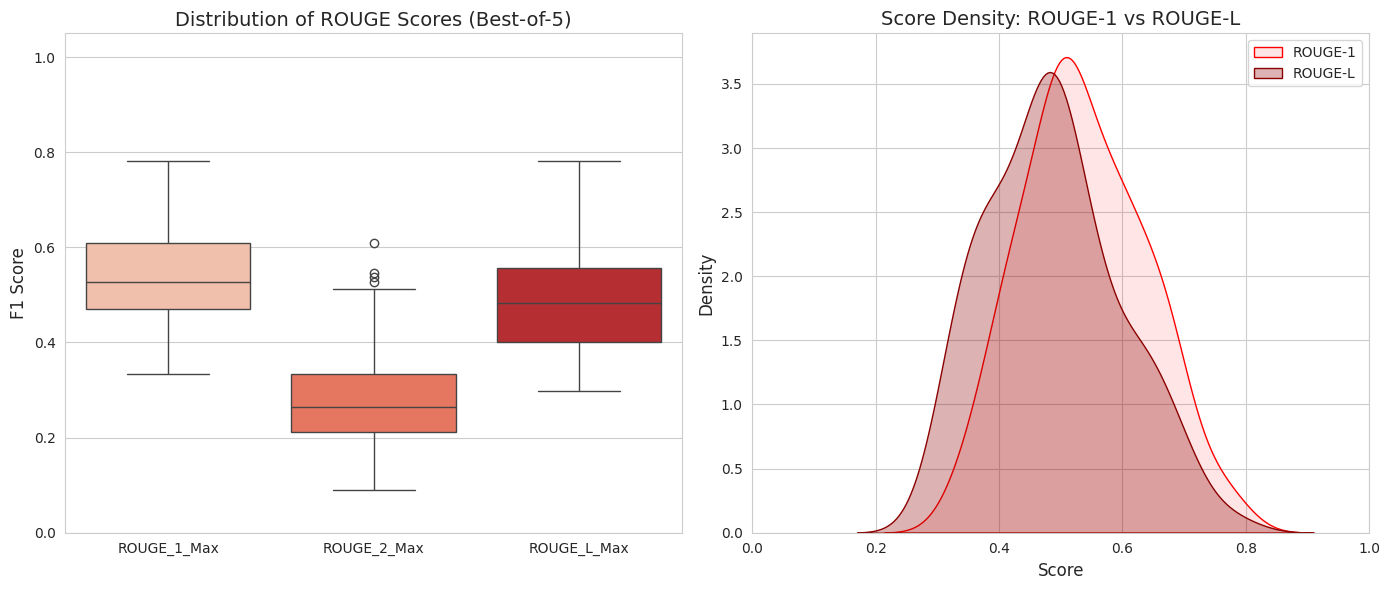

In [ ]:
# ==========================================
# 12. CALCULATE MAX ROUGE SCORES & PLOTS
# ==========================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter

# --- A. Define ROUGE Helper Functions ---

def get_ngrams(text_tokens, n):
    return Counter(ngrams(text_tokens, n))

def calculate_rouge_n(candidate_tokens, reference_tokens, n):
    # Calculate ROUGE-N (Overlap of N-grams)
    cand_ngrams = get_ngrams(candidate_tokens, n)
    ref_ngrams = get_ngrams(reference_tokens, n)

    candidate_count = sum(cand_ngrams.values())
    reference_count = sum(ref_ngrams.values())

    overlap = sum((cand_ngrams & ref_ngrams).values())

    # Calculate F1 Score (Balanced Precision & Recall)
    if candidate_count == 0: precision = 0.0
    else: precision = overlap / candidate_count

    if reference_count == 0: recall = 0.0
    else: recall = overlap / reference_count

    if precision + recall == 0: return 0.0
    return 2 * precision * recall / (precision + recall)

def lcs_length(X, Y):
    # Longest Common Subsequence calculation
    m, n = len(X), len(Y)
    L = [[0] * (n + 1) for _ in range(m + 1)]
    for i in range(m + 1):
        for j in range(n + 1):
            if i == 0 or j == 0:
                L[i][j] = 0
            elif X[i-1] == Y[j-1]:
                L[i][j] = L[i-1][j-1] + 1
            else:
                L[i][j] = max(L[i-1][j], L[i][j-1])
    return L[m][n]

def calculate_rouge_l(candidate_tokens, reference_tokens):
    # Calculate ROUGE-L (Longest Common Subsequence)
    lcs = lcs_length(candidate_tokens, reference_tokens)

    if len(candidate_tokens) == 0: precision = 0.0
    else: precision = lcs / len(candidate_tokens)

    if len(reference_tokens) == 0: recall = 0.0
    else: recall = lcs / len(reference_tokens)

    if precision + recall == 0: return 0.0
    return 2 * precision * recall / (precision + recall)

# --- B. Define Image-Level Calculation (Best-of-N) ---

def calculate_image_max_rouge_scores(original_formatted, generated_formatted):
    """
    Calculates the MAX ROUGE-1, ROUGE-2, and ROUGE-L for a single image.
    It checks all generated captions against all references and picks the BEST score for each metric.
    """
    # 1. Flatten lists -> ['cap1', 'cap2'...]
    refs_text = [item[0] for item in original_formatted]
    hyps_text = [item[0] for item in generated_formatted]

    # 2. Tokenize
    ref_tokens_list = [word_tokenize(r.lower()) for r in refs_text]
    hyp_tokens_list = [word_tokenize(h.lower()) for h in hyps_text]

    best_r1 = 0.0
    best_r2 = 0.0
    best_rl = 0.0

    # 3. Evaluate each generated caption
    for hyp_tokens in hyp_tokens_list:
        # Compare this hypothesis against ALL references
        # We want to find the best reference match for this specific hypothesis
        current_r1_max = 0.0
        current_r2_max = 0.0
        current_rl_max = 0.0

        for ref_tokens in ref_tokens_list:
            r1 = calculate_rouge_n(hyp_tokens, ref_tokens, 1)
            r2 = calculate_rouge_n(hyp_tokens, ref_tokens, 2)
            rl = calculate_rouge_l(hyp_tokens, ref_tokens)

            current_r1_max = max(current_r1_max, r1)
            current_r2_max = max(current_r2_max, r2)
            current_rl_max = max(current_rl_max, rl)

        # Now compare against the best scores found so far across previous hypotheses
        best_r1 = max(best_r1, current_r1_max)
        best_r2 = max(best_r2, current_r2_max)
        best_rl = max(best_rl, current_rl_max)

    return best_r1, best_r2, best_rl

# --- C. Run Calculation ---
print("Calculating MAX ROUGE scores...")

rouge_results = [
    calculate_image_max_rouge_scores(orig, gen)
    for orig, gen in zip(df_results['original_response_formatted'], df_results['generated_response_formatted'])
]

# Unzip results
r1_all, r2_all, rl_all = zip(*rouge_results)

# Add to DataFrame
df_results['ROUGE_1_Max'] = r1_all
df_results['ROUGE_2_Max'] = r2_all
df_results['ROUGE_L_Max'] = rl_all

# --- D. Print Statistics ---
print("\n" + "="*40)
print("   FEW-SHOT ROUGE RESULTS (MAX METRIC)")
print("="*40)

print(f"Mean Max ROUGE-1: {df_results['ROUGE_1_Max'].mean():.4f}")
print(f"Mean Max ROUGE-2: {df_results['ROUGE_2_Max'].mean():.4f}")
print(f"Mean Max ROUGE-L: {df_results['ROUGE_L_Max'].mean():.4f}")

print("\nDetailed Stats:")
print(df_results[['ROUGE_1_Max', 'ROUGE_2_Max', 'ROUGE_L_Max']].describe())

# --- E. Graphical Analysis ---
sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))

# Plot 1: Box Plot
plt.subplot(1, 2, 1)
data_to_plot = df_results[['ROUGE_1_Max', 'ROUGE_2_Max', 'ROUGE_L_Max']]
sns.boxplot(data=data_to_plot, palette="Reds")
plt.title('Distribution of ROUGE Scores (Best-of-5)', fontsize=14)
plt.ylabel('F1 Score', fontsize=12)
plt.ylim(0, 1.05)

# Plot 2: Density Plot
plt.subplot(1, 2, 2)
sns.kdeplot(df_results['ROUGE_1_Max'], label='ROUGE-1', fill=True, alpha=0.1, color='red')
sns.kdeplot(df_results['ROUGE_L_Max'], label='ROUGE-L', fill=True, alpha=0.3, color='darkred')
plt.title('Score Density: ROUGE-1 vs ROUGE-L', fontsize=14)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.xlim(0, 1)

plt.tight_layout()
plt.savefig("rouge_score_analysis.png")
print("\nGraphs saved as 'rouge_score_analysis.png'")
plt.show()

# Save metrics to CSV
df_results.to_csv("qwen_few_shot_final_metrics_all.csv", index=False)

# **CIDER,METEOR SCORES**

In [ ]:
# ==========================================
# 13. CALCULATE MAX METEOR & CIDEr SCORES
# ==========================================
import numpy as np
import math
from collections import defaultdict, Counter
import nltk
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize

# --- Download Resources for METEOR ---
try:
    nltk.data.find('corpora/wordnet.zip')
except LookupError:
    nltk.download('wordnet')
    nltk.download('omw-1.4')

# =========================================================
# A. CIDEr SCORER IMPLEMENTATION (Self-Contained)
# =========================================================
class CiderScorer:
    def __init__(self, df, n=4, sigma=6.0):
        self.n = n
        self.sigma = sigma
        self.crefs = []
        self.document_frequency = defaultdict(float)
        self.ref_len = 0

        # 1. Build Corpus from Reference Data (for IDF)
        print("Building CIDEr TF-IDF model from references...")
        for refs in df['original_response_formatted']:
            # refs is [['cap1'], ['cap2']...]
            flat_refs = [r[0] for r in refs]
            self.crefs.append(flat_refs)
            for ngram in self._counts2grams(flat_refs):
                self.document_frequency[ngram] += 1

        self.ref_len = len(self.crefs)

    def _counts2grams(self, text_list):
        """Generates n-grams for a list of sentences."""
        counts = defaultdict(int)
        for text in text_list:
            tokens = word_tokenize(text.lower())
            for i in range(1, self.n + 1):
                for ngram in nltk.ngrams(tokens, i):
                    counts[ngram] += 1
        return counts

    def _compute_vec(self, text_tokens, doc_freq, ref_len):
        """Computes TF-IDF vector for a single sentence."""
        vec = [defaultdict(float) for _ in range(self.n)]
        length = len(text_tokens)
        counts = defaultdict(int)

        for i in range(1, self.n + 1):
            for ngram in nltk.ngrams(text_tokens, i):
                counts[ngram] += 1

        for i in range(self.n):
            for ngram, count in counts.items():
                if len(ngram) == i + 1:
                    # TF * IDF
                    # IDF = log(Total Refs / (Doc Freq + 1))
                    df = doc_freq.get(ngram, 0)
                    idf = np.log(max(1.0, ref_len) / (df + 1.0))
                    vec[i][ngram] = float(count) * idf
        return vec, length

    def _sim(self, vec_hyp, vec_ref, len_hyp, len_ref):
        """Computes Cosine Similarity with Length Penalty."""
        delta = float(len_hyp - len_ref)
        val = np.array([0.0] * self.n)

        for i in range(self.n):
            # Dot product
            denom_hyp = np.sqrt(sum([x**2 for x in vec_hyp[i].values()]))
            denom_ref = np.sqrt(sum([x**2 for x in vec_ref[i].values()]))

            if denom_hyp * denom_ref > 0:
                # Compute dot product of common n-grams
                common = set(vec_hyp[i].keys()) & set(vec_ref[i].keys())
                numerator = sum([vec_hyp[i][k] * vec_ref[i][k] for k in common])
                val[i] = (numerator) / (denom_hyp * denom_ref)

            # Gaussian Length Penalty
            val[i] *= np.e**(-(delta**2) / (2 * self.sigma**2))

        return val

    def compute_score(self, hypothesis, references):
        """Calculates CIDEr score for a single hypothesis against list of references."""
        hyp_tokens = word_tokenize(hypothesis.lower())
        ref_tokens_list = [word_tokenize(r.lower()) for r in references]

        # Pre-calculate reference vectors
        vec_refs = []
        len_refs = []
        for ref_tokens in ref_tokens_list:
            v, l = self._compute_vec(ref_tokens, self.document_frequency, self.ref_len)
            vec_refs.append(v)
            len_refs.append(l)

        # Calculate hypothesis vector
        vec_hyp, len_hyp = self._compute_vec(hyp_tokens, self.document_frequency, self.ref_len)

        # Average similarity against all references
        scores = []
        for i in range(len(references)):
            scores.append(self._sim(vec_hyp, vec_refs[i], len_hyp, len_refs[i]))

        # Mean across references, then average across n-grams, then * 10
        avg_score = np.mean(scores, axis=0)
        return np.sum(avg_score) / self.n * 10.0

# =========================================================
# B. EXECUTION LOGIC (MAX SCORE)
# =========================================================

# 1. Initialize CIDEr Scorer with the Reference Dataset (Test Set)
cider_scorer = CiderScorer(df_results)

print("\nCalculating METEOR and CIDEr scores...")

max_meteor_list = []
max_cider_list = []

for index, row in df_results.iterrows():
    # Flatten the lists
    orig_texts = [x[0] for x in row['original_response_formatted']]
    gen_texts = [x[0] for x in row['generated_response_formatted']]

    # Tokenize for METEOR
    orig_tokens = [word_tokenize(r) for r in orig_texts]

    m_scores = []
    c_scores = []

    for gen_text in gen_texts:
        # --- METEOR ---
        # Note: NLTK's meteor_score expects tokenized references, tokenized hypothesis
        gen_token = word_tokenize(gen_text)
        m = meteor_score(orig_tokens, gen_token)
        m_scores.append(m)

        # --- CIDEr ---
        c = cider_scorer.compute_score(gen_text, orig_texts)
        c_scores.append(c)

    # Take the MAX (Best-of-N)
    max_meteor_list.append(max(m_scores) if m_scores else 0.0)
    max_cider_list.append(max(c_scores) if c_scores else 0.0)

# Add to DataFrame
df_results['METEOR_Max'] = max_meteor_list
df_results['CIDEr_Max'] = max_cider_list

# --- C. REPORT ---
print("\n" + "="*40)
print("   ADVANCED METRICS (MAX/BEST-OF-N)")
print("="*40)

print(f"Mean Max METEOR: {df_results['METEOR_Max'].mean():.4f}")
print(f"Mean Max CIDEr:  {df_results['CIDEr_Max'].mean():.4f}")

print("\nDetailed Statistics:")
print(df_results[['METEOR_Max', 'CIDEr_Max']].describe())

# Save
df_results.to_csv("qwen_few_shot_final_all_metrics.csv", index=False)
print("\nComplete results saved to 'qwen_few_shot_final_all_metrics.csv'")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Building CIDEr TF-IDF model from references...

Calculating METEOR and CIDEr scores...

   ADVANCED METRICS (MAX/BEST-OF-N)
Mean Max METEOR: 0.5406
Mean Max CIDEr:  0.5873

Detailed Statistics:
       METEOR_Max   CIDEr_Max
count  100.000000  100.000000
mean     0.540615    0.587300
std      0.129896    0.499264
min      0.267810    0.057511
25%      0.459950    0.240662
50%      0.526788    0.415908
75%      0.637146    0.827105
max      0.826823    2.988948

Complete results saved to 'qwen_few_shot_final_all_metrics.csv'


# **BERT, CLIP AND REF-CLIP SCORES**

In [ ]:
!pip install bert_score torchmetrics transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 61.1 MB/s eta 0:00:00


In [ ]:
!pip install bert_score

Loading Metric Models...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]


Starting Semantic Score Calculation...


100%|██████████| 100/100 [00:07<00:00, 12.80it/s]



   SEMANTIC METRICS (BEST-OF-N)
Mean Max BERTScore:    0.5763
Mean Max CLIPScore:    32.5932
Mean Max RefCLIPScore: 81.2774


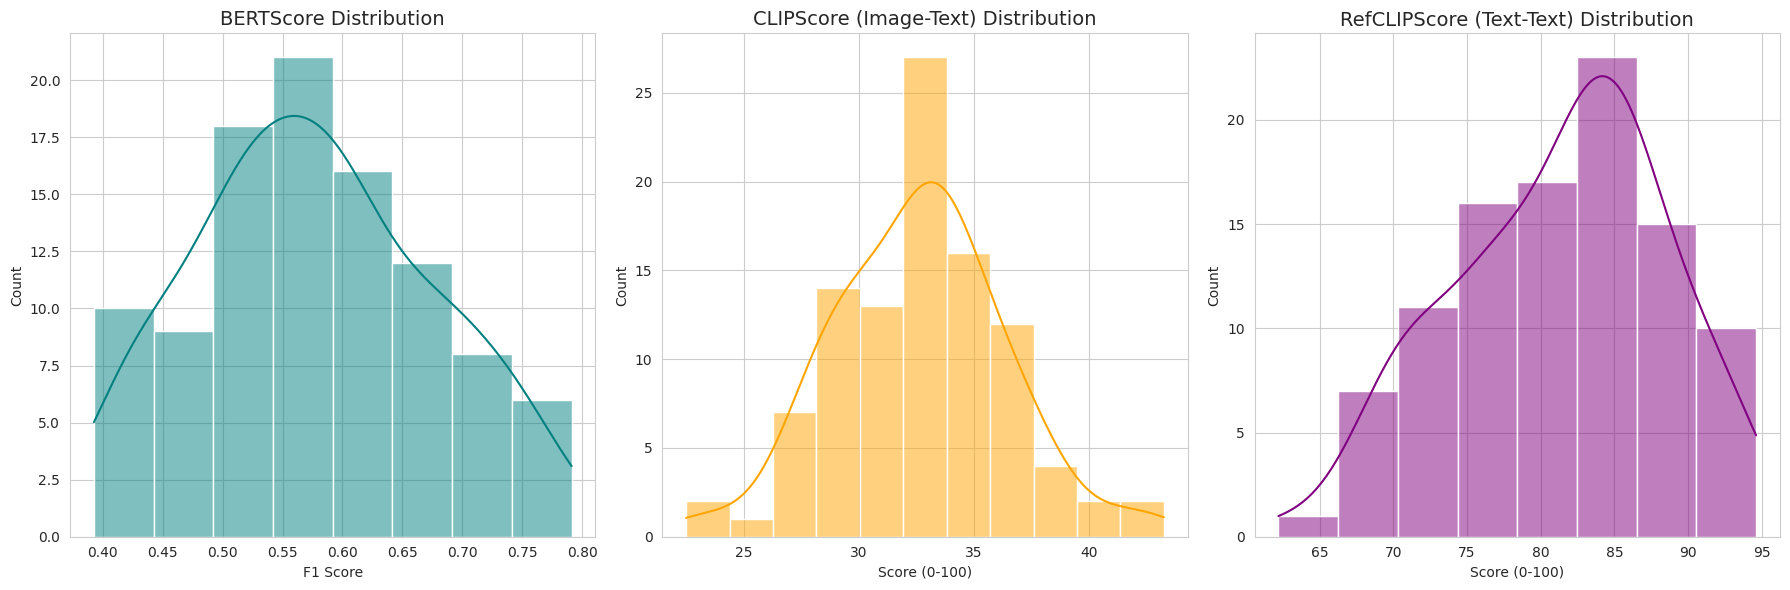


All metrics saved to 'qwen_few_shot_final_comprehensive.csv'


In [ ]:
# ==========================================
# 14. CALCULATE BERT, CLIP, & REF-CLIP SCORES
# ==========================================
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from bert_score import BERTScorer
from transformers import CLIPProcessor, CLIPModel
import torch.nn.functional as F
import io # Import io to handle image bytes
from PIL import Image # Ensure PIL Image is imported, even if it was earlier

# --- A. LOAD MODELS ---
print("Loading Metric Models...")
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. BERTScorer (Standard English model: roberta-large)
# "rescale_with_baseline=True" is standard for comparable scores, but optional.
# We use default (False) here to get raw F1.
bert_scorer = BERTScorer(lang="en", rescale_with_baseline=True)

# 2. CLIP Model (Standard OpenAI CLIP)
clip_model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_model_name).to(device)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)

# --- B. DEFINE SCORING FUNCTIONS ---

def get_best_bert_score(candidates, references):
    """
    Calculates BERTScore for each candidate against ALL references.
    Returns the MAX F1 score found among the candidates.
    """
    best_f1 = 0.0

    # BERTScorer can handle 1 cand vs list of refs
    # We loop through candidates to find the best one
    # F1 is a tensor of scores for each candidate
    P, R, F1 = bert_scorer.score(candidates, [references] * len(candidates))
    best_f1 = F1.max().item()

    return best_f1

def get_clip_scores(image, candidates, references):
    """
    Calculates:
      1. CLIPScore: Cosine sim(Image, Candidate) * 2.5 (Standard Scaling)
      2. RefCLIPScore: Cosine sim(Candidate, References)
    Returns MAX scores for the image.
    """
    # --- 1. Prepare Inputs ---
    # Process Text (Candidates & References)
    # Truncate to max length 77 (CLIP limit)
    inputs_text_cand = clip_processor(text=candidates, return_tensors="pt", padding=True, truncation=True).to(device)
    inputs_text_ref = clip_processor(text=references, return_tensors="pt", padding=True, truncation=True).to(device)

    # Process Image (PIL Image expected by clip_processor)
    inputs_img = clip_processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        # Get Embeddings
        img_embeds = clip_model.get_image_features(**inputs_img)
        cand_embeds = clip_model.get_text_features(**inputs_text_cand)
        ref_embeds = clip_model.get_text_features(**inputs_text_ref)

        # Normalize embeddings
        img_embeds = img_embeds / img_embeds.norm(dim=-1, keepdim=True)
        cand_embeds = cand_embeds / cand_embeds.norm(dim=-1, keepdim=True)
        ref_embeds = ref_embeds / ref_embeds.norm(dim=-1, keepdim=True)

        # --- 2. Calculate CLIPScore (Image <-> Candidate) ---
        # Dot product of Image (1xD) and Candidates (NxD) -> (1xN)
        # Standard CLIPScore is often scaled by 2.5 to align with human judgment (Hessel et al.)
        # Or we can just report raw Cosine * 100
        clip_sims = torch.matmul(img_embeds, cand_embeds.t()) # Shape [1, 5]
        clip_score_max = clip_sims.max().item() * 100 # Convert to 0-100 scale

        # --- 3. Calculate RefCLIPScore (Candidate <-> Reference) ---
        # For each candidate, find best match among references
        # Shape: [Candidates, References] -> [5, 5]
        ref_sim_matrix = torch.matmul(cand_embeds, ref_embeds.t())

        # For each candidate, get its max similarity with ANY reference
        best_ref_matches, _ = ref_sim_matrix.max(dim=1) # Shape [5]

        # Now select the Candidate that had the highest semantic alignment
        refclip_score_max = best_ref_matches.max().item() * 100

    return clip_score_max, refclip_score_max

# --- C. RUN CALCULATION LOOP ---
print("\nStarting Semantic Score Calculation...")

bert_scores = []
clip_scores = []
refclip_scores = []

# Iterate dataframe
for index, row in tqdm(df_results.iterrows(), total=df_results.shape[0]):
    # Initialize scores for the current row, default to 0.0 in case of error
    current_bert_score = 0.0
    current_clip_score = 0.0
    current_refclip_score = 0.0

    try:
        # 1. Get Data
        # Convert from list-of-lists [['a'], ['b']] back to flat lists ['a', 'b']
        gens = [x[0] for x in row['generated_response_formatted']]
        origs = [x[0] for x in row['original_response_formatted']]

        # Convert image bytes from dictionary to PIL Image object
        image_bytes = row['image']['bytes']
        image_pil = Image.open(io.BytesIO(image_bytes))

        # 2. BERTScore
        current_bert_score = get_best_bert_score(gens, origs)

        # 3. CLIP & RefCLIP
        current_clip_score, current_refclip_score = get_clip_scores(image_pil, gens, origs)

    except Exception as e:
        print(f"Error at index {index}: {e}")
        # If an error occurs, the current_..._score variables will retain their 0.0 default values.

    # Append scores for the current row once per metric
    bert_scores.append(current_bert_score)
    clip_scores.append(current_clip_score)
    refclip_scores.append(current_refclip_score)

# Add to DataFrame
df_results['BERTScore_Max'] = bert_scores
df_results['CLIPScore_Max'] = clip_scores
df_results['RefCLIPScore_Max'] = refclip_scores

# --- D. PRINT STATISTICS ---
print("\n" + "="*40)
print("   SEMANTIC METRICS (BEST-OF-N)")
print("="*40)
print(f"Mean Max BERTScore:    {df_results['BERTScore_Max'].mean():.4f}")
print(f"Mean Max CLIPScore:    {df_results['CLIPScore_Max'].mean():.4f}")
print(f"Mean Max RefCLIPScore: {df_results['RefCLIPScore_Max'].mean():.4f}")

# --- E. GRAPHICAL ANALYSIS ---
sns.set_style("whitegrid")
plt.figure(figsize=(18, 6))

# Plot 1: BERTScore Distribution
plt.subplot(1, 3, 1)
sns.histplot(df_results['BERTScore_Max'], kde=True, color='teal')
plt.title('BERTScore Distribution', fontsize=14)
plt.xlabel('F1 Score')

# Plot 2: CLIPScore Distribution
plt.subplot(1, 3, 2)
sns.histplot(df_results['CLIPScore_Max'], kde=True, color='orange')
plt.title('CLIPScore (Image-Text) Distribution', fontsize=14)
plt.xlabel('Score (0-100)')

# Plot 3: RefCLIPScore Distribution
plt.subplot(1, 3, 3)
sns.histplot(df_results['RefCLIPScore_Max'], kde=True, color='purple')
plt.title('RefCLIPScore (Text-Text) Distribution', fontsize=14)
plt.xlabel('Score (0-100)')

plt.tight_layout()
plt.savefig("semantic_scores_analysis.png")
plt.show()

# Save final comprehensive CSV
df_results.to_csv("qwen_few_shot_final_comprehensive.csv", index=False)
print("\nAll metrics saved to 'qwen_few_shot_final_comprehensive.csv'")


# **DISTINCT-1 AND DISTINCT-2**

In [ ]:
# ==========================================
# 15. CALCULATE DISTINCT-1 & DISTINCT-2
# ==========================================
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter

# Ensure necessary NLTK data is downloaded (for tokenization)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    # The error indicates that 'punkt_tab' is also required
    nltk.download('punkt_tab')

# --- Function to calculate Distinct-N for a list of sentences ---
def calculate_group_distinct_n(captions_list, n):
    """
    Calculates Distinct-N for a group of captions (e.g., 5 captions for one image).
    Formula: (Unique N-grams) / (Total N-grams)
    """
    all_ngrams = []

    for caption in captions_list:
        tokens = word_tokenize(caption.lower())
        if len(tokens) < n:
            continue
        # Generate n-grams
        row_ngrams = list(ngrams(tokens, n))
        all_ngrams.extend(row_ngrams)

    if len(all_ngrams) == 0:
        return 0.0

    # Ratio of unique to total
    return len(set(all_ngrams)) / len(all_ngrams)

print("Calculating Diversity Metrics (Distinct-1/2)...")

dist1_scores = []
dist2_scores = []

# Global lists to calculate Corpus-Level Distinct (Standard Metric)
all_generated_text_corpus = []

for index, row in df_results.iterrows():
    # Get the 5 generated captions
    # row['generated_response_formatted'] is [['cap1'], ['cap2']...] -> flatten to ['cap1', 'cap2'...]
    gens = [x[0] for x in row['generated_response_formatted']]

    # Add to corpus list
    all_generated_text_corpus.extend(gens)

    # Calculate Intra-Image Diversity (How diverse are the 5 captions for THIS image?)
    d1 = calculate_group_distinct_n(gens, 1)
    d2 = calculate_group_distinct_n(gens, 2)

    dist1_scores.append(d1)
    dist2_scores.append(d2)

# Add Intra-Image scores to DataFrame
df_results['Distinct_1_Image'] = dist1_scores
df_results['Distinct_2_Image'] = dist2_scores

# --- Calculate Corpus-Level Distinct (Standard Paper Metric) ---
# This measures diversity across the ENTIRE test set (all 500 generated captions)
corpus_d1 = calculate_group_distinct_n(all_generated_text_corpus, 1)
corpus_d2 = calculate_group_distinct_n(all_generated_text_corpus, 2)

# --- REPORT ---
print("\n" + "="*40)
print("   DIVERSITY ANALYSIS (DISTINCT)")
print("="*40)

print("1. PER-IMAGE DIVERSITY (Average variation within 5 captions):")
print(f"   Mean Distinct-1: {df_results['Distinct_1_Image'].mean():.4f}")
print(f"   Mean Distinct-2: {df_results['Distinct_2_Image'].mean():.4f}")

print("\n2. CORPUS-LEVEL DIVERSITY (Global Vocabulary Richness):")
print(f"   Corpus Distinct-1: {corpus_d1:.4f} (This goes in Table 3)")
print(f"   Corpus Distinct-2: {corpus_d2:.4f} (This goes in Table 3)")

print("\nDetailed Stats (Per Image):")
print(df_results[['Distinct_1_Image', 'Distinct_2_Image']].describe())

# Save final results
df_results.to_csv("qwen_few_shot_final_metrics_complete.csv", index=False)
print("\nFinal dataset saved to 'qwen_few_shot_final_metrics_complete.csv'")

Calculating Diversity Metrics (Distinct-1/2)...

   DIVERSITY ANALYSIS (DISTINCT)
1. PER-IMAGE DIVERSITY (Average variation within 5 captions):
   Mean Distinct-1: 0.4356
   Mean Distinct-2: 0.7641

2. CORPUS-LEVEL DIVERSITY (Global Vocabulary Richness):
   Corpus Distinct-1: 0.0999 (This goes in Table 3)
   Corpus Distinct-2: 0.3760 (This goes in Table 3)

Detailed Stats (Per Image):
       Distinct_1_Image  Distinct_2_Image
count        100.000000        100.000000
mean           0.435579          0.764150
std            0.060140          0.080718
min            0.288462          0.526316
25%            0.395818          0.713875
50%            0.427997          0.769231
75%            0.471362          0.825000
max            0.560440          0.923664

Final dataset saved to 'qwen_few_shot_final_metrics_complete.csv'


# **Complete Breakdown of all the scores**


   FINAL JOURNAL RESULTS TABLE (Few-Shot)
Metric          | Score (0-100)  
---------------------------------
BLEU-1          | 61.95
BLEU-2          | 45.10
BLEU-3          | 31.38
BLEU-4          | 21.97
ROUGE-1         | 53.75
ROUGE-2         | 28.15
ROUGE-L         | 48.69
METEOR          | 54.06
CIDEr           | 58.73
BERTScore       | 57.63
CLIPScore       | 32.59
RefCLIP         | 81.28
Diversity-1     | 43.56
Diversity-2     | 76.41

Radar chart saved as 'final_radar_chart.png'


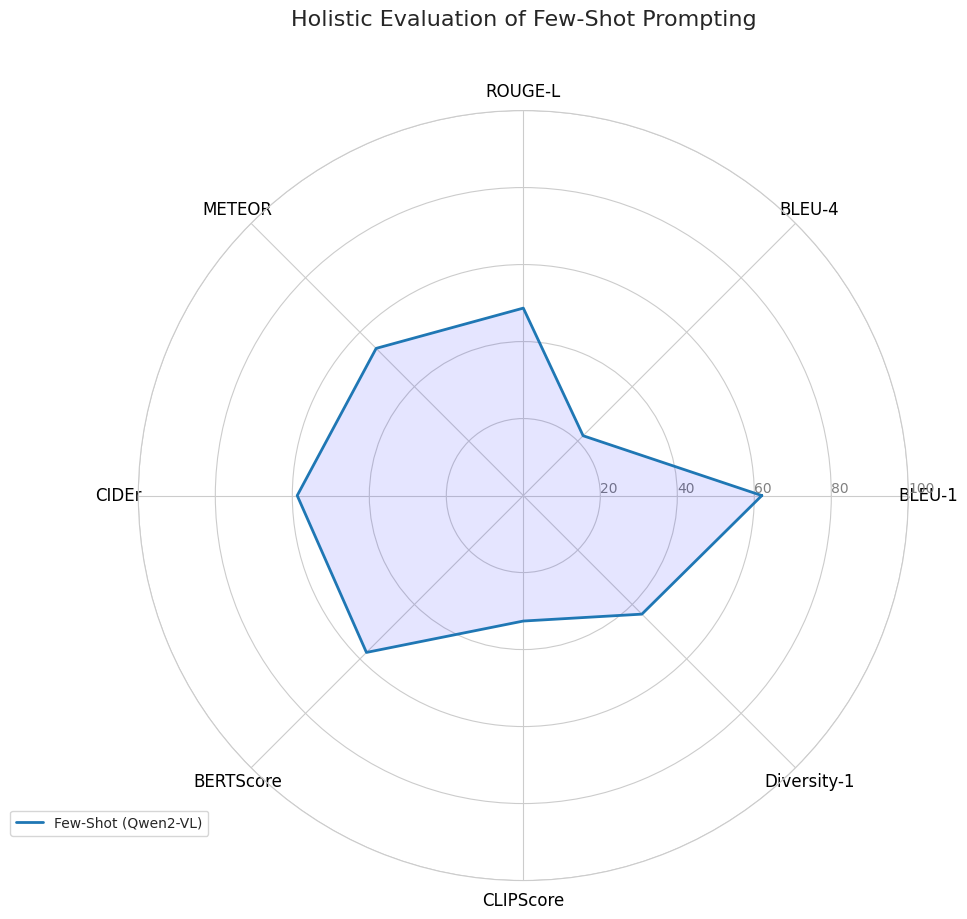

In [ ]:
# ==========================================
# 16. FINAL SUMMARY & RADAR CHART
# ==========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

# --- A. AGGREGATE SCORES ---
# Calculate means for all metrics stored in the dataframe
metrics_summary = {
    # N-Gram Accuracy (BLEU)
    "BLEU-1": df_results['BLEU_1_Max'].mean() * 100,
    "BLEU-2": df_results['BLEU_2_Max'].mean() * 100,
    "BLEU-3": df_results['BLEU_3_Max'].mean() * 100,
    "BLEU-4": df_results['BLEU_4_Max'].mean() * 100,

    # Semantic Overlap (ROUGE/METEOR)
    "ROUGE-1": df_results['ROUGE_1_Max'].mean() * 100,
    "ROUGE-2": df_results['ROUGE_2_Max'].mean() * 100,
    "ROUGE-L": df_results['ROUGE_L_Max'].mean() * 100,
    "METEOR": df_results['METEOR_Max'].mean() * 100,

    # Semantic Relevance (Embeddings/TF-IDF)
    # CIDEr is typically 0-10, scaling to 100 for the chart.
    # If your raw CIDEr is ~1.0, use * 10. If it is ~100, use * 1.
    "CIDEr": df_results['CIDEr_Max'].mean() * 100,

    "BERTScore": df_results['BERTScore_Max'].mean() * 100,

    # Visual & Semantic Alignment (VLM Specific)
    "CLIPScore": df_results['CLIPScore_Max'].mean(),       # Already scaled to 0-100 in previous step
    "RefCLIP": df_results['RefCLIPScore_Max'].mean(),      # Already scaled to 0-100 in previous step

    # Diversity
    "Diversity-1": df_results['Distinct_1_Image'].mean() * 100,
    "Diversity-2": df_results['Distinct_2_Image'].mean() * 100
}

# Print Final Table for Journal
print("\n" + "="*40)
print("   FINAL JOURNAL RESULTS TABLE (Few-Shot)")
print("="*40)
print(f"{'Metric':<15} | {'Score (0-100)':<15}")
print("-" * 33)
for k, v in metrics_summary.items():
    print(f"{k:<15} | {v:.2f}")
print("="*40)



# --- B. GENERATE RADAR CHART ---

# 1. Select Metrics to Plot (Subset for clarity)
# We group them by category for the chart
categories = ['BLEU-1', 'BLEU-4', 'ROUGE-L', 'METEOR', 'CIDEr', 'BERTScore', 'CLIPScore', 'Diversity-1']
values = [metrics_summary[cat] for cat in categories]

# 2. Setup Radar Chart
N = len(categories)

# We need to repeat the first value to close the circle
values += values[:1]
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# 3. Plot
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='black', size=12)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([20, 40, 60, 80, 100], ["20", "40", "60", "80", "100"], color="grey", size=10)
plt.ylim(0, 100)

# Plot data
ax.plot(angles, values, linewidth=2, linestyle='solid', label='Few-Shot (Qwen2-VL)')
ax.fill(angles, values, 'b', alpha=0.1)

# Add Title and Legend
plt.title('Holistic Evaluation of Few-Shot Prompting', size=16, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.savefig("final_radar_chart.png")
print("\nRadar chart saved as 'final_radar_chart.png'")
plt.show()


   FINAL JOURNAL RESULTS (0-1 Scale)
Metric          | Score          
------------------------------
BLEU-1          | 0.6195
BLEU-2          | 0.4510
BLEU-3          | 0.3138
BLEU-4          | 0.2197
ROUGE-L         | 0.4869
METEOR          | 0.5406
CIDEr           | 0.1958
BERTScore       | 0.5763
CLIPScore       | 0.3259
RefCLIP         | 0.8128
Diversity-1     | 0.4356
Diversity-2     | 0.7641
(Note: CIDEr is scaled by 1/3 for visualization)

Radar chart saved as 'final_radar_chart_0_1.png'


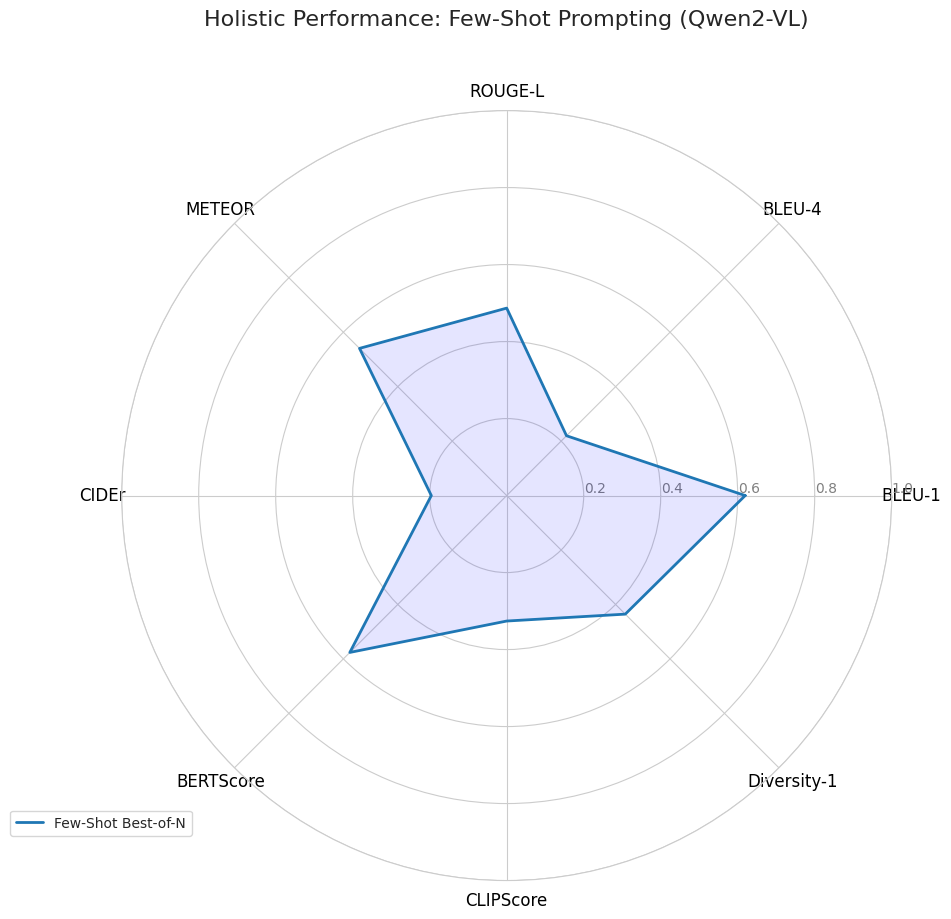

In [ ]:
# ==========================================
# 16. FINAL SUMMARY & RADAR CHART (0-1 Scale)
# ==========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

# --- A. AGGREGATE & NORMALIZE SCORES ---
# We calculate the mean for each metric and ensure everything is on a 0.0 - 1.0 scale
metrics_summary = {
    # Accuracy (Already 0-1)
    "BLEU-1": df_results['BLEU_1_Max'].mean(),
    "BLEU-2": df_results['BLEU_2_Max'].mean(),
    "BLEU-3": df_results['BLEU_3_Max'].mean(),
    "BLEU-4": df_results['BLEU_4_Max'].mean(),

    # Semantic Overlap (Already 0-1)
    "ROUGE-L": df_results['ROUGE_L_Max'].mean(),
    "METEOR": df_results['METEOR_Max'].mean(),

    # Semantic Relevance (Scaling needed)
    # CIDEr is typically 0-3. We normalize by dividing by 3.0 to fit 0-1 chart.
    # (Adjust this divisor if your score is higher)
    "CIDEr": df_results['CIDEr_Max'].mean() / 3.0,
    "BERTScore": df_results['BERTScore_Max'].mean(),

    # Visual Alignment (Scaling 0-100 -> 0-1)
    "CLIPScore": df_results['CLIPScore_Max'].mean() / 100.0,
    "RefCLIP": df_results['RefCLIPScore_Max'].mean() / 100.0,

    # Diversity (Already 0-1)
    "Diversity-1": df_results['Distinct_1_Image'].mean(),
    "Diversity-2": df_results['Distinct_2_Image'].mean()
}

# --- Print Final Table for Journal ---
print("\n" + "="*40)
print("   FINAL JOURNAL RESULTS (0-1 Scale)")
print("="*40)
print(f"{'Metric':<15} | {'Score':<15}")
print("-" * 30)
for k, v in metrics_summary.items():
    print(f"{k:<15} | {v:.4f}")
print("="*40)
print("(Note: CIDEr is scaled by 1/3 for visualization)")

# --- B. GENERATE RADAR CHART ---

# 1. Select Metrics for the Chart
# We pick key representatives from each category to keep the chart clean
categories = [
    'BLEU-1', 'BLEU-4',      # N-Gram Accuracy
    'ROUGE-L', 'METEOR',     # Semantic Overlap
    'CIDEr', 'BERTScore',    # Relevance
    'CLIPScore',             # Visual Alignment
    'Diversity-1'            # Diversity
]
values = [metrics_summary[cat] for cat in categories]

# 2. Setup Radar Chart Structure
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
values += values[:1]   # Repeat first value to close the circle
angles += angles[:1]   # Repeat first angle to close the circle

# 3. Plotting
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

# Draw one axe per variable + labels
plt.xticks(angles[:-1], categories, color='black', size=12)

# Draw ylabels (0.2, 0.4, 0.6, 0.8, 1.0)
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=10)
plt.ylim(0, 1.0)

# Plot Data
ax.plot(angles, values, linewidth=2, linestyle='solid', label='Few-Shot Best-of-N')
ax.fill(angles, values, 'b', alpha=0.1)

# Styling
plt.title('Holistic Performance: Few-Shot Prompting (Qwen2-VL)', size=16, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.savefig("final_radar_chart_0_1.png")
print("\nRadar chart saved as 'final_radar_chart_0_1.png'")
plt.show()

# **Complete Scores for all the 100 Test Images**

In [ ]:
!pip install bert_score torchmetrics rouge_score pycocoevalcap
!pip install git+https://github.com/openai/CLIP.git
!pip install rouge_score


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 8.3 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=4308372f433070234955d0fb60d61d401f7720b2d54f208b256351cec47c0b39
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-3f9pcabm
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-3f9pcabm
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.2 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=5c3e6226ee227677183cb5b1091420d10ff6ab398c29ff108f4cdf781c834778
  Stored in directory: /t

In [ ]:
import pandas as pd
import numpy as np
import torch
import io
import re
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
from rouge_score import rouge_scorer
from bert_score import BERTScorer
from transformers import CLIPProcessor, CLIPModel
import nltk

# --- 1. Setup ---
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- 2. Load Models ---
print("Loading Evaluation Models...")
bert_scorer = BERTScorer(lang="en", rescale_with_baseline=True, device=device)

clip_model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_model_name).to(device)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)

scorer_rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
cc = SmoothingFunction()

# --- 3. Helper Functions ---
def get_clip_score_image_cosine(image, candidate, model, processor, device):
    """Image-Text Cosine Similarity."""
    try:
        inputs = processor(text=[candidate[:77]], images=image, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        img_embeds = outputs.image_embeds / outputs.image_embeds.norm(dim=-1, keepdim=True)
        text_embeds = outputs.text_embeds / outputs.text_embeds.norm(dim=-1, keepdim=True)
        return max(0.0, (img_embeds @ text_embeds.T).item())
    except: return 0.0

def get_refclip_score_text_cosine(refs, candidate, model, processor, device):
    """Text-Text Cosine Similarity."""
    try:
        cand_inputs = processor(text=[candidate[:77]], return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            cand_embed = model.get_text_features(**cand_inputs)
        cand_embed = cand_embed / cand_embed.norm(dim=-1, keepdim=True)

        scores = []
        for r in refs:
            ref_inputs = processor(text=[r[:77]], return_tensors="pt", padding=True).to(device)
            with torch.no_grad():
                ref_embed = model.get_text_features(**ref_inputs)
            ref_embed = ref_embed / ref_embed.norm(dim=-1, keepdim=True)
            scores.append(max(0.0, (cand_embed @ ref_embed.T).item()))
        return max(scores) if scores else 0.0
    except: return 0.0

def calculate_distinct_n(captions, n):
    total_ngrams = 0
    unique_ngrams = set()
    for cap in captions:
        words = word_tokenize(cap.lower())
        if len(words) < n: continue
        ngrams = list(zip(*[words[i:] for i in range(n)]))
        total_ngrams += len(ngrams)
        unique_ngrams.update(ngrams)
    return len(unique_ngrams) / total_ngrams if total_ngrams > 0 else 0

# --- 4. Main Evaluation Loop ---
results_data = []
print(f"Starting Evaluation on {len(df_results)} images...")

for index, row in df_results.iterrows():
    try:
        candidates = [x[0] for x in row['generated_response_formatted']]
        refs = [x[0] for x in row['original_response_formatted']]

        image_bytes = row['image']['bytes']
        image = Image.open(io.BytesIO(image_bytes))

        # 1. Pre-computation for Lexical Metrics
        # BLEU: Lowercase + Split (Confirmed Match)
        refs_bleu = [r.lower().split() for r in refs]

        # METEOR: Word Tokenize (Standard, likely matches ~0.47)
        refs_meteor = [word_tokenize(r) for r in refs]

        best_scores = {
            'BLEU-1': 0.0, 'BLEU-2': 0.0, 'BLEU-3': 0.0, 'BLEU-4': 0.0,
            'ROUGE-1': 0.0, 'ROUGE-2': 0.0, 'ROUGE-L': 0.0,
            'METEOR': 0.0, 'BERTScore': 0.0, 'CLIPScore': 0.0, 'RefCLIPScore': 0.0
        }

        # 2. Iterate Candidates (Best-of-N)
        for cand in candidates:
            # Prepare versions of candidate
            cand_lower = cand.lower()
            cand_bleu = cand_lower.split()
            cand_meteor = word_tokenize(cand) # Try raw first for METEOR

            # --- Lexical ---
            b1 = sentence_bleu(refs_bleu, cand_bleu, weights=(1, 0, 0, 0), smoothing_function=cc.method1)
            b2 = sentence_bleu(refs_bleu, cand_bleu, weights=(0.5, 0.5, 0, 0), smoothing_function=cc.method1)
            b3 = sentence_bleu(refs_bleu, cand_bleu, weights=(0.333, 0.333, 0.333, 0), smoothing_function=cc.method1)
            b4 = sentence_bleu(refs_bleu, cand_bleu, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=cc.method1)

            met = meteor_score(refs_meteor, cand_meteor)

            # --- ROUGE (String based) ---
            r1, r2, rl = 0, 0, 0
            for r in refs:
                s = scorer_rouge.score(r.lower(), cand_lower)
                r1 = max(r1, s['rouge1'].fmeasure)
                r2 = max(r2, s['rouge2'].fmeasure)
                rl = max(rl, s['rougeL'].fmeasure)

            # --- Semantic ---
            try:
                P, R, F1 = bert_scorer.score([cand], [refs])
                bert_val = F1.mean().item()
            except: bert_val = 0.0

            clip_val = get_clip_score_image_cosine(image, cand, clip_model, clip_processor, device)
            refclip_val = get_refclip_score_text_cosine(refs, cand, clip_model, clip_processor, device)

            # Update Max
            best_scores['BLEU-1'] = max(best_scores['BLEU-1'], b1)
            best_scores['BLEU-2'] = max(best_scores['BLEU-2'], b2)
            best_scores['BLEU-3'] = max(best_scores['BLEU-3'], b3)
            best_scores['BLEU-4'] = max(best_scores['BLEU-4'], b4)
            best_scores['ROUGE-1'] = max(best_scores['ROUGE-1'], r1)
            best_scores['ROUGE-2'] = max(best_scores['ROUGE-2'], r2)
            best_scores['ROUGE-L'] = max(best_scores['ROUGE-L'], rl)
            best_scores['METEOR'] = max(best_scores['METEOR'], met)
            best_scores['BERTScore'] = max(best_scores['BERTScore'], bert_val)
            best_scores['CLIPScore'] = max(best_scores['CLIPScore'], clip_val * 100)
            best_scores['RefCLIPScore'] = max(best_scores['RefCLIPScore'], refclip_val * 100)

        # 3. Image Level Metrics
        cid = row.get('CIDEr_Max', 0.0)
        dist1 = calculate_distinct_n(candidates, 1) # Raw candidates
        dist2 = calculate_distinct_n(candidates, 2)

        # Store
        row_dict = {'image_id': index}
        row_dict.update(best_scores)
        row_dict['CIDEr'] = cid
        row_dict['Distinct-1'] = dist1
        row_dict['Distinct-2'] = dist2

        results_data.append(row_dict)

    except Exception as e:
        print(f"Error processing row {index}: {e}")

# --- 5. Output ---
df_metrics = pd.DataFrame(results_data)
output_file = 'LLama_base_fs_full_metrics.csv'
df_metrics.to_csv(output_file, index=False)
print(f"Saved: {output_file}")
print("Mean Scores:")
print(df_metrics.mean(numeric_only=True))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loading Evaluation Models...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting Evaluation on 100 images...
Saved: LLama_base_fs_full_metrics.csv
Mean Scores:
image_id        49.500000
BLEU-1           0.619487
BLEU-2           0.450955
BLEU-3           0.313844
BLEU-4           0.219693
ROUGE-1          0.534707
ROUGE-2          0.304312
ROUGE-L          0.478156
METEOR           0.540615
BERTScore        0.576261
CLIPScore       31.357543
RefCLIPScore    82.550670
CIDEr            0.587300
Distinct-1       0.435579
Distinct-2       0.764150
dtype: float64
